In [2]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/multi_agent_sim")
from multi_agent_sim import MultiAgentSim

In [3]:

social_network_params_high_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (2,3),
}

n_agents = 1000
expected_total_outside_infs = 5
time_horizon = 7 * 12
main_params = {
    'n_agents': n_agents,
    'use_contact_tracing': True,
    'use_adaptive_testing': True,
    'use_surveillance_testing': True
}

infection_dynamics_params = {
    'forward_gen_alpha': 8,
    'forward_gen_beta_hyperparams': (5,5),
    'detectability_curve_type': 'optimistic',
    'self_reporting_multiplier': 0.8,
    'self_reporting_delay': 3,
    'init_infection_rate': 0,
    'use_deterministic_infection_counts': True,
    'outside_infection_rate': expected_total_outside_infs / (n_agents * time_horizon)
}

ct_params = {
    'ct_recall_window': 4,
    'ct_delay_distribution': [1/3,1/3,1/3], # uniform over 0, 1, 2 days delay
    'ct_recall_rate': 0.5
}

at_params = {
    'at_delay_distribution': [1/5] * 5,
    'at_net_size_contact_multiplier': 10,
    'at_recall_rate': 0.9
}

st_params = {
    'st_testing_window': 3,
    'st_missed_test_rate': 0.1
}

def init_high_var_sim(R0):
    social_network_params_high_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_high_var, 
                         ct_params, at_params, st_params)

social_network_params_low_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (5,6),
}

def init_low_var_sim(R0):
    social_network_params_low_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_low_var, 
                         ct_params, at_params, st_params)

In [4]:
def sample_trajectory(R0, at_multiplier, st_testing_window, 
                      use_adaptive_testing = True, use_surveillance_testing = True):
    st_params['st_testing_window'] = st_testing_window
    at_params['at_net_size_contact_multiplier'] = at_multiplier
    main_params['use_adaptive_testing'] = use_adaptive_testing
    main_params['use_surveillance_testing'] = use_surveillance_testing
    sim = init_low_var_sim(R0)
    infection_counts = [len(sim.infection.get_cum_infected_agent_ids())]
    init_infection_counts = infection_counts[0]
    for _ in range(7*12):
        sim.step()
        infection_counts.append(len(sim.infection.get_cum_infected_agent_ids()))
    total_tests = sim.get_total_tests()
    return total_tests, infection_counts, init_infection_counts, infection_counts[-1]

# Description:
Have (maybe one or two) nominal adaptive testing protocol, and 1-2 nominal surveillance testing protocol, and 1-2 nominal contact trace only protocols, and simulate all of them over multiple R0 values, & record total infections as well as total test usage

sample_trajectory (defined above) lets us sample a single trajectory for a particular value of at_multiplier, of st_testing_window

In [5]:
from multiprocessing import Process
import pickle


def sim_target_f(R0, at_mult, st_window, use_at, use_st, ntrajectories, pickle_file_loc):
    results = [sample_trajectory(R0, at_mult, st_window, use_at, use_st) for _ in range(ntrajectories)]
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(R0, at_mult, st_window, use_at, use_st, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (R0, at_mult, st_window, use_at, use_st, ntrajectories, pickle_file_loc))
    p.start()
    return p

In [6]:
R0s_to_try = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

adaptive_test_policies = [(8, 4, True, True), 
                          (12, 7, True, True), 
                          (12, 14, True, True)]
no_use = 1
surveillance_test_policies = [(no_use, 4, False, True), 
                              (no_use, 7, False, True), 
                              (no_use, 14, False, True)]
contact_trace_policy = [(no_use, no_use, False, False)]

all_policies = adaptive_test_policies + surveillance_test_policies + contact_trace_policy

ntrajectories = 250

sim_ps = {}

from datetime import datetime

for R0 in R0s_to_try:
    print("on R0 {}\n".format(R0))
    for policy in all_policies:
        at_mult, st_window, use_at, use_st = policy
        print("on policy {}\n".format(policy))
        print("Timestamp: {}\n".format(datetime.now()))
        sim_ps[(R0, policy)] = run_sims_new_process(R0, at_mult, st_window, 
                                                    use_at, use_st, ntrajectories, str((R0, policy)) + ".pickle")
    
print("launched {} processes".format(sim_ps.values()))
for p in sim_ps.values():
    p.join()


on R0 1

on policy (8, 4, True, True)

Timestamp: 2020-12-31 18:51:29.155394

on policy (12, 7, True, True)

Timestamp: 2020-12-31 18:51:29.166912

on policy (12, 14, True, True)

Timestamp: 2020-12-31 18:51:29.172426

on policy (1, 4, False, True)

Timestamp: 2020-12-31 18:51:29.178139

on policy (1, 7, False, True)

Timestamp: 2020-12-31 18:51:29.184574

on policy (1, 14, False, True)

Timestamp: 2020-12-31 18:51:29.190244

on policy (1, 1, False, False)

Timestamp: 2020-12-31 18:51:29.196341

on R0 1.5

on policy (8, 4, True, True)

Timestamp: 2020-12-31 18:51:29.202937

on policy (12, 7, True, True)

Timestamp: 2020-12-31 18:51:29.209655

on policy (12, 14, True, True)

Timestamp: 2020-12-31 18:51:29.215146

on policy (1, 4, False, True)

Timestamp: 2020-12-31 18:51:29.221557

on policy (1, 7, False, True)

Timestamp: 2020-12-31 18:51:29.226932

on policy (1, 14, False, True)

Timestamp: 2020-12-31 18:51:29.233498

on policy (1, 1, False, False)

Timestamp: 2020-12-31 18:51:29.2393

In [7]:
print("hi")

hi


In [8]:
sim_results = {}
for R0 in R0s_to_try:
    print("on R0 {}\n".format(R0))
    for policy in all_policies:
        sim_results[(R0, policy)] = pickle.load(open(str((R0, policy)) + ".pickle", "rb"))

on R0 1

on R0 1.5

on R0 2

on R0 2.5

on R0 3

on R0 3.5

on R0 4

on R0 4.5

on R0 5



In [ ]:
len(sim_results)

In [10]:
avg_infxns_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        if R0 == 5 and policy == (16,7,True,True):
            continue
        avg_infxns = np.mean([r[-1] for r in sim_results[(R0, policy)]])
        avg_infxns_by_policy[policy].append(avg_infxns)

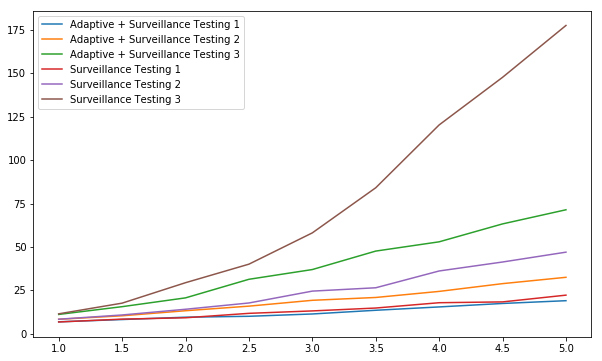

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

policy_names = {
    (8,4,True,True): "Adaptive + Surveillance Testing 1",
    (12,7,True,True): "Adaptive + Surveillance Testing 2",
    (12,14,True,True): "Adaptive + Surveillance Testing 3",
    (1,4, False, True): "Surveillance Testing 1",
    (1,7,False, True): "Surveillance Testing 2",
    (1, 14, False, True): "Surveillance Testing 3",
    (1,1,False,False): "Contact Tracing Only"
}

plt.figure(figsize=(10,6))

for policy in all_policies:
    if policy == (1,1,False,False):
        continue
    plt.plot(R0s_to_try, avg_infxns_by_policy[policy], label=policy_names[policy])

plt.legend(loc='best')
plt.show()

In [11]:
avg_test_usage_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        avg_tests = np.mean([r[0] for r in sim_results[(R0, policy)]])
        avg_test_usage_by_policy[policy].append(avg_tests)

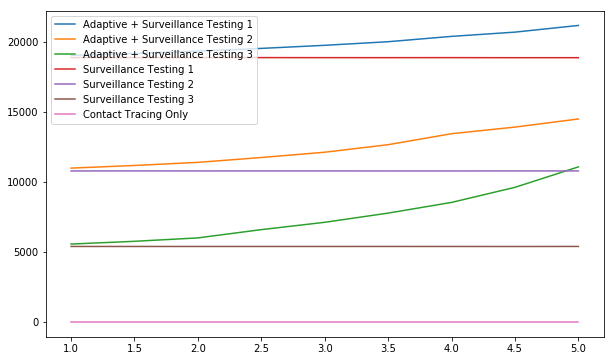

In [12]:
plt.figure(figsize=(10,6))

for policy in all_policies:
    plt.plot(R0s_to_try, avg_test_usage_by_policy[policy], label=policy_names[policy])

plt.legend(loc='best')
plt.show()

# Run more comprehensive simulations

In [12]:
R0s_to_try = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

adaptive_test_policies = [(8, 20, True, True), 
                          (6, 20,True,True),
                          (12,20,True,True),
                          (10,20,True,True),
                          (6,10,True,True),
                          (8,10,True,True),
                          (10,10,True,True),
                          (12, 10, True, True),
                          (6,17,True,True),
                          (8,17,True,True),
                          (10,17,True,True),
                          (12, 17, True, True)]
no_use = 1
surveillance_test_policies = [(no_use, 10, False, True), 
                              (no_use, 17, False, True), 
                              (no_use, 20, False, True)]
contact_trace_policy = []#[(no_use, no_use, False, False)]

all_policies = adaptive_test_policies + surveillance_test_policies + contact_trace_policy

ntrajectories = 250

sim_ps = {}

from datetime import datetime

for R0 in R0s_to_try:
    print("on R0 {}\n".format(R0))
    for policy in all_policies:
        at_mult, st_window, use_at, use_st = policy
        print("on policy {}\n".format(policy))
        print("Timestamp: {}\n".format(datetime.now()))
        sim_ps[(R0, policy)] = run_sims_new_process(R0, at_mult, st_window, 
                                                    use_at, use_st, ntrajectories, str((R0, policy)) + ".pickle_v2")
    
print("launched {} processes".format(sim_ps.values()))
for p in sim_ps.values():
    p.join()


on R0 1

on policy (8, 20, True, True)

Timestamp: 2021-01-01 16:16:07.944861

on policy (6, 20, True, True)

Timestamp: 2021-01-01 16:16:07.956363

on policy (12, 20, True, True)

Timestamp: 2021-01-01 16:16:07.964041

on policy (10, 20, True, True)

Timestamp: 2021-01-01 16:16:07.970453

on policy (6, 10, True, True)

Timestamp: 2021-01-01 16:16:07.979702

on policy (8, 10, True, True)

Timestamp: 2021-01-01 16:16:07.987692

on policy (10, 10, True, True)

Timestamp: 2021-01-01 16:16:07.994838

on policy (12, 10, True, True)

Timestamp: 2021-01-01 16:16:08.003098

on policy (6, 17, True, True)

Timestamp: 2021-01-01 16:16:08.010587

on policy (8, 17, True, True)

Timestamp: 2021-01-01 16:16:08.019529

on policy (10, 17, True, True)

Timestamp: 2021-01-01 16:16:08.026346

on policy (12, 17, True, True)

Timestamp: 2021-01-01 16:16:08.034333

on policy (1, 10, False, True)

Timestamp: 2021-01-01 16:16:08.041576

on policy (1, 17, False, True)

Timestamp: 2021-01-01 16:16:08.048055

on 

on policy (10, 17, True, True)

Timestamp: 2021-01-01 16:16:09.259865

on policy (12, 17, True, True)

Timestamp: 2021-01-01 16:16:09.274900

on policy (1, 10, False, True)

Timestamp: 2021-01-01 16:16:09.286986

on policy (1, 17, False, True)

Timestamp: 2021-01-01 16:16:09.298910

on policy (1, 20, False, True)

Timestamp: 2021-01-01 16:16:09.314468

on R0 5

on policy (8, 20, True, True)

Timestamp: 2021-01-01 16:16:09.324320

on policy (6, 20, True, True)

Timestamp: 2021-01-01 16:16:09.359748

on policy (12, 20, True, True)

Timestamp: 2021-01-01 16:16:09.375812

on policy (10, 20, True, True)

Timestamp: 2021-01-01 16:16:09.392161

on policy (6, 10, True, True)

Timestamp: 2021-01-01 16:16:09.405709

on policy (8, 10, True, True)

Timestamp: 2021-01-01 16:16:09.419438

on policy (10, 10, True, True)

Timestamp: 2021-01-01 16:16:09.461005

on policy (12, 10, True, True)

Timestamp: 2021-01-01 16:16:09.477387

on policy (6, 17, True, True)

Timestamp: 2021-01-01 16:16:09.491693

on

Process Process-180:
Traceback (most recent call last):
  File "/home/jmc678/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jmc678/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-0136a1bd060f>", line 6, in sim_target_f
    results = [sample_trajectory(R0, at_mult, st_window, use_at, use_st) for _ in range(ntrajectories)]
  File "<ipython-input-5-0136a1bd060f>", line 6, in <listcomp>
    results = [sample_trajectory(R0, at_mult, st_window, use_at, use_st) for _ in range(ntrajectories)]
  File "<ipython-input-4-b36333d498ab>", line 11, in sample_trajectory
    sim.step()
  File "/home/jmc678/covid_data/group-testing/src/multi_agent_sim/multi_agent_sim.py", line 86, in step
    self.at.trigger_adaptive_test(agent_id, self.curr_day)
  File "/home/jmc678/covid_data/group-testing/src/multi_agent_sim/adaptive_testing.py", line 34, in trigger_ad

In [14]:
print('hi')

hi


In [13]:
sim_results = {}
for R0 in R0s_to_try:
    for policy in all_policies:
        sim_results[(R0, policy)] = pickle.load(open(str((R0, policy)) + ".pickle_v2", "rb"))
print("loaded {} simulation results".format(len(sim_results)))

FileNotFoundError: [Errno 2] No such file or directory: '(4.5, (12, 17, True, True)).pickle_v2'

In [16]:
avg_infxns_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        avg_infxns = np.mean([r[-1] for r in sim_results[(R0, policy)]])
        avg_infxns_by_policy[policy].append(avg_infxns)
        
avg_test_usage_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        avg_tests = np.mean([r[0] for r in sim_results[(R0, policy)]])
        avg_test_usage_by_policy[policy].append(avg_tests)
        
print("finished computing test usage and infections by policy")

finished computing test usage and infections by policy


plotting infections vs. R0 for policies using a surveillance test frequency of 4 days


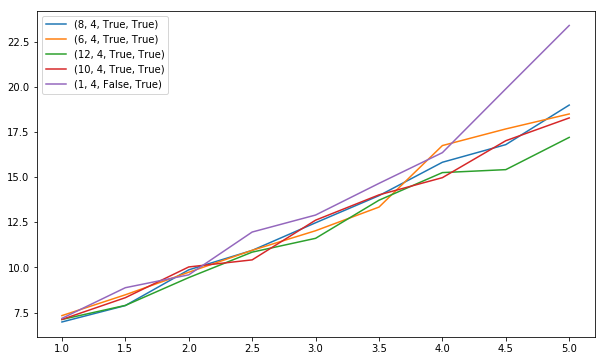

In [18]:

surveillance_freq = 4

print("plotting infections vs. R0 for policies using a surveillance test frequency of {} days".format(surveillance_freq))

plt.figure(figsize=(10,6))

for policy in all_policies:
    if policy[1] != surveillance_freq: 
        continue
    plt.plot(R0s_to_try, avg_infxns_by_policy[policy], label=str(policy))

plt.legend(loc='best')
plt.show()

plotting infections vs. R0 for policies using a surveillance test frequency of 7 days


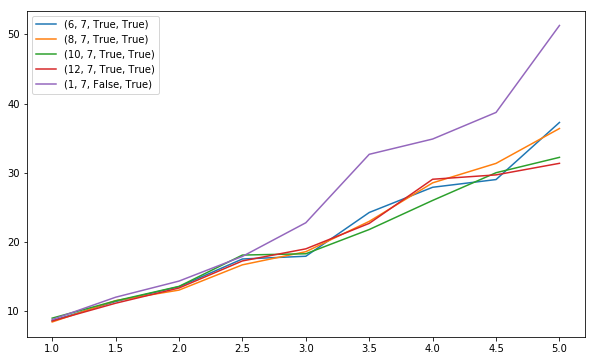

In [19]:

surveillance_freq = 7

print("plotting infections vs. R0 for policies using a surveillance test frequency of {} days".format(surveillance_freq))

plt.figure(figsize=(10,6))

for policy in all_policies:
    if policy[1] != surveillance_freq: 
        continue
    plt.plot(R0s_to_try, avg_infxns_by_policy[policy], label=str(policy))

plt.legend(loc='best')
plt.show()